## 作业2：ADAMS和RK4数值积分的实现
仿照run_euler函数的实现，在modsim中实现Adams和四阶Runge-Kutta法，并使用炮弹发射仿真比较Euler、Adams和RK4三种数值积分的精度。实现run_adams和run_rk4函数。

In [119]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [120]:
m = UNITS.meter
s = UNITS.second

g = 9.8 * m/s**2

init_z = State(y=100.0 * m, v=0.0 * m/s)
init_x = State(y=0.0 * m, v=500.0 * m/s)

t_end = 6 * s
dt = 0.5 * s

system_z = System(init=init_z, g=g, t_end=t_end, dt=dt)
system_x = System(init=init_x, t_end=t_end, dt=dt)

def slope_func_z(state, t, system):
    y, v = state
    
    dydt = v
    dvdt = -system.g
    
    return dydt, dvdt

def slope_func_x(state, t, system):
    y, v = state
    
    dydt = v
    dvdt = 0.0 * m/s**2
    
    return dydt, dvdt

In [121]:
def run_adams(system, slope_func,n, **options):
    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0+2*dt, t_end, dt) * get_units(t_end)
    
    #初始化slpoes
    slopes=[0]
    j=n
    if j>1:
        slopes.extend([0])
        j=j-1
        
    #初始化frame
    y1 = frame.row[t_0]
    slopes_initialize= slope_func(y1, 0, system)
    y2 = [y + slope * dt for y, slope in zip(y1, slopes_initialize)]
    t = dt
    frame.row[t] = y2
    slopes_initialize = slope_func(y2, dt, system)
    y2 = [y + slope * dt for y, slope in zip(y2, slopes_initialize)]
    t=t+dt
    frame.row[t] = y2

    # run the solver rk4
    for t1 in ts:
        y1 = frame.row[t1]

        f3=slope_func(y1, t1, system)
        x4 = [y + K * dt for y, K in zip(y1, f3)]
        f4=slope_func(x4, t1+dt, system)
        x2=frame.row[round(t1-dt,5)]
        f2=slope_func(x2, round(t1-dt,5), system)
        x1=frame.row[round(t1-dt*2,5)]
        f1=slope_func(x1, round(t1-dt,5), system)
        
        for i in range(n):  #n为阶数
            slopes[i] =(9*f4[i]+19*f3[i]-5*f2[i]+f1[i])/24
        
        y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
        t2 = t1 + dt
        frame.row[t2] = y2
         
    details = ModSimSeries(dict(message="Success"))
    return frame, details

In [122]:
def run_rk4(system, slope_func,n, **options):
    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)
    
    #初始化slpoes
    slopes=[0]
    j=n
    if j>1:
        slopes.extend([0])
        j=j-1

    # run the solver rk4
    for t1 in ts:
        y1 = frame.row[t1]

        K1=slope_func(y1, t1, system)
        yK1 = [y + K1/2 * dt for y, K1 in zip(y1, K1)]
        K2=slope_func(yK1, t1+dt/2, system)
        yK2 = [y + K2/2 * dt for y, K2 in zip(y1, K2)]
        K3=slope_func(yK2, t1+dt/2, system)
        yK3 = [y + K3 * dt for y, K3 in zip(y1, K3)]
        K4=slope_func(yK3, t1+dt, system)
        
        for i in range(n):  #n为阶数
            slopes[i] =(K1[i]+2*K2[i]+2*K3[i]+K4[i])/6
        
        y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
        t2 = t1 + dt
        frame.row[t2] = y2
         
    details = ModSimSeries(dict(message="Success"))
    return frame, details

In [123]:
results_z_rk4, details_z = run_rk4(system_z, slope_func_z,2)

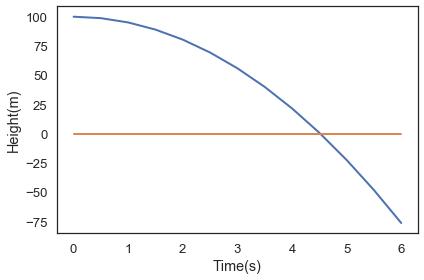

In [124]:
results_x_rk4, details_x = run_rk4(system_x, slope_func_x,2)

plot(results_z_rk4.y )
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

x=[0,1,2,3,4,5,6]
y=[0,0,0,0,0,0,0]
plot(x,y)

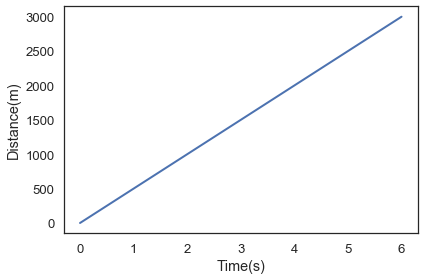

In [125]:
plot(results_x_rk4.y)
decorate(xlabel='Time(s)',
         ylabel='Distance(m)')

In [126]:
results_z_adams, details_z = run_adams(system_z, slope_func_z,2)

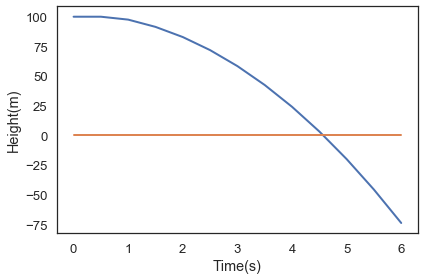

In [127]:
results_x_adams, details_x = run_rk4(system_x, slope_func_x,2)

plot(results_z_adams.y )
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

x=[0,1,2,3,4,5,6]
y=[0,0,0,0,0,0,0]
plot(x,y)

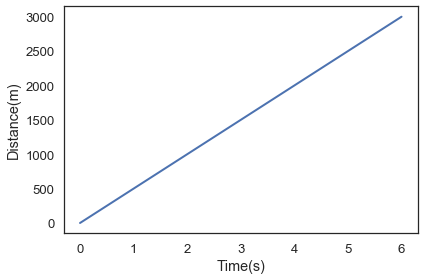

In [128]:
plot(results_x_adams.y)
decorate(xlabel='Time(s)',
         ylabel='Distance(m)')

In [129]:
results_z_euler, details_z = run_euler(system_z, slope_func_z)
results_x_euler, details_x = run_euler(system_x, slope_func_x)

In [154]:
results_z_rk4_y=[]
results_z_adams_y=[]
results_z_euler_y=[]
for i in range(100):
    if results_z_rk4.y[i] >=0:
        results_z_rk4_y.extend([results_z_rk4.y[i]])
    else:
        results_z_rk4_y.extend([results_z_rk4.y[i]])
        break
for i in range(100):
    if results_z_rk4.y[i] >=0:
        results_z_adams_y.extend([results_z_adams.y[i]])
    else:
        results_z_adams_y.extend([results_z_adams.y[i]])
        break
for i in range(100):
    if results_z_rk4.y[i] >=0:
        results_z_euler_y.extend([results_z_euler.y[i]])
    else:
        results_z_euler_y.extend([results_z_euler.y[i]])
        break

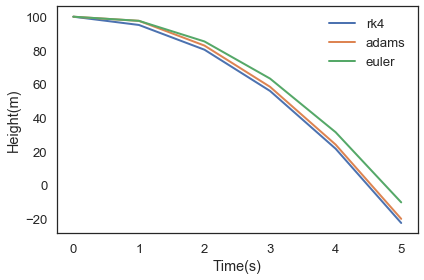

In [155]:
plot(results_z_rk4_y ,label='rk4')
plot(results_z_adams_y,label='adams' )
plot(results_z_euler_y,label='euler' )
decorate(xlabel='Time(s)',
         ylabel='Height(m)',
        )

可见Adams和RK4的精度相似，远大于euler